# Continuous Contract Index Futures

## Introduction 

Futures are an excellent way of gaining access and exposure to various asset classes. The contracts are often much more liquid than their underlyings, long- and short positions can be entered equally easy, and there is no cash changing hands involved by entering a position "

Contract Index Futures Assmblying in the first part
In the second part we will enrich our analysis with some visual and quantitative components from the area of technical analysis. 

## Imports

In [1]:
import pickle
import numpy as np 
import pandas as pd
import eikon as ek
import configparser
import warnings
warnings.filterwarnings('ignore')

Visualization imports.

In [2]:
from pylab import plt
plt.style.use('ggplot')
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Setup Eikon Connection

In [3]:
#config = configparser.ConfigParser() 
#config.read('logins.cfg')

In [4]:
#ek.set_app_id(config['eikon']['app_id'])

## Data Retrieval and Time-Series Inspection

Below we define functions for firstly catching **Spliced Contracts** Futures time-series from **Eikon** and then generating **Continuous Futures** based on the **Perpetual** (for 10 and 40 roll over days) and the **Panama Method**. **Futures Expiries** are read from an Excel File. We write everything in a dict called **data_dict**.

In the following we show a function from which data has been received originally. For holding the data set steady, we save everything to disk and use that source for later analysis.

In [5]:
def get_fut_front_back(start_date, end_date, front_contr = ['FGBLc1', 'FGBMc1', 'FGBSc1'],
                back_contr = ['FGBLc2', 'FGBMc2', 'FGBSc2'], fields = ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOLUME']):
    '''
    Fetch daily Futures data for front and back contract and return as dict of dfs. The Eikon API seems
    to limit one time data accesss. Therefore we slice into 5y data pieces. 
    :param start_date: str. of format 'yyyy-mm-dd'
    :param end_date: str. of format 'yyyy-mm-dd'
    :param front_contr: list of str.
    :param back_contr: list of str.
    :param fields: list of str.
    :return: dict of DataFrames.
    '''
    data_dict = {}
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    fields = fields
    counter = 0
    
    while int((end_date - start_date).days) > 1827:
        temp_end_date = start_date + pd.DateOffset(years=5)        
        if counter == 0:
            for i in range(len(front_contr)):
                data_dict[front_contr[i][0:-2]] = ek.get_timeseries([front_contr[i], back_contr[i]],
                                              fields=fields,
                                              start_date=str(start_date),
                                              end_date=str(temp_end_date),
                                              interval='daily')
            counter += 1
        else:
            for i in range(len(front_contr)):
                new_df = ek.get_timeseries([front_contr[i], back_contr[i]],
                                              fields=fields,
                                              start_date=str(start_date),
                                              end_date=str(temp_end_date),
                                              interval='daily')
                data_dict[front_contr[i][0:-2]] = pd.concat([data_dict[front_contr[i][0:-2]], new_df])
        start_date = temp_end_date
    if counter == 0:    
        for i in range(len(front_contr)):
                data_dict[front_contr[i][0:-2]] = ek.get_timeseries([front_contr[i], back_contr[i]],
                                              fields=fields,
                                              start_date=str(start_date),
                                              end_date=str(end_date),
                                              interval='daily')
    else:
        for i in range(len(front_contr)):
            new_df = ek.get_timeseries([front_contr[i], back_contr[i]],
                                              fields=fields,
                                              start_date=str(start_date),
                                              end_date=str(end_date),
                                              interval='daily')
            data_dict[front_contr[i][0:-2]] = pd.concat([data_dict[front_contr[i][0:-2]], new_df])
    return data_dict
    

### Original Data Import

In [6]:
#data_dict = get_fut_front_back('2000-1-1', '2018-03-29')

In [7]:
## Original instructions to save down data_dict
#pickle_out = open("frozen_data.pickle","wb")
#pickle.dump(data_dict, pickle_out)
#pickle_out.close()

### Loading Data from Disk

In [8]:
pickle_in = open("frozen_data.pickle","rb")
data_dict = pickle.load(pickle_in)

We will also need the Futures expiry dates for all chained contracts. However, as the EIKON Python API is still a beta version, it seems that those data fields are not available at the time of writing. Therefore Futures expiries have been downloaded via the Excel API and will be simply imported as an *.xlsx file.

In [9]:
expiry_dates = pd.read_excel('Futures_Expiries.xlsx', header=None, index_col=0, squeeze=1)
expiry_dates = pd.to_datetime(expiry_dates.values, dayfirst = True)
expiry_dates # Datetimeindex for all Futures Expiries (Bund, Bobl, Schatz mature on the same day)

DatetimeIndex(['2000-03-08', '2000-06-08', '2000-09-07', '2000-12-07',
               '2001-03-08', '2001-06-07', '2001-09-06', '2001-12-06',
               '2002-03-07', '2002-06-06', '2002-09-06', '2002-12-06',
               '2003-03-06', '2003-06-06', '2003-09-08', '2003-12-08',
               '2004-03-08', '2004-06-08', '2004-09-08', '2004-12-08',
               '2005-03-08', '2005-06-08', '2005-09-08', '2005-12-08',
               '2006-03-08', '2006-06-08', '2006-09-07', '2006-12-07',
               '2007-03-08', '2007-06-07', '2007-09-06', '2007-12-06',
               '2008-03-06', '2008-06-06', '2008-09-08', '2008-12-08',
               '2009-03-06', '2009-06-08', '2009-09-08', '2009-12-08',
               '2010-03-08', '2010-06-08', '2010-09-08', '2010-12-08',
               '2011-03-08', '2011-06-08', '2011-09-08', '2011-12-08',
               '2012-03-08', '2012-06-07', '2012-09-06', '2012-12-06',
               '2013-03-07', '2013-06-06', '2013-09-06', '2013-12-06',
      

### Short Inspection of our data

In [10]:
data_dict.keys() # FGBL = Bund Future, FGBM = Bobl Future, FGBS = Schatz Future

dict_keys(['FGBL', 'FGBM', 'FGBS'])

In [11]:
data_dict['FGBL'].head() # FGBLc1 = Front Contract, FGBLc2 = Back Contract

Security    FGBLc1                                    FGBLc2                  \
Field         OPEN     LOW    HIGH   CLOSE    VOLUME    OPEN     LOW    HIGH   
Date                                                                           
2000-01-03  103.80  103.11  104.00  103.32  361159.0  102.97  102.45  102.97   
2000-01-04  103.00  102.47  103.34  103.16  719659.0  102.11  101.84  102.40   
2000-01-05  103.30  102.75  103.49  102.89  801158.0  102.54  102.15  102.54   
2000-01-06  103.00  102.59  103.10  102.75  560412.0  101.97  101.89  101.98   
2000-01-07  102.99  102.81  103.70  103.59  698518.0  102.12  102.12  102.79   

Security                    
Field        CLOSE  VOLUME  
Date                        
2000-01-03  102.53   667.0  
2000-01-04  102.33  2341.0  
2000-01-05  102.07  1246.0  
2000-01-06  101.91  2958.0  
2000-01-07  102.76  5927.0

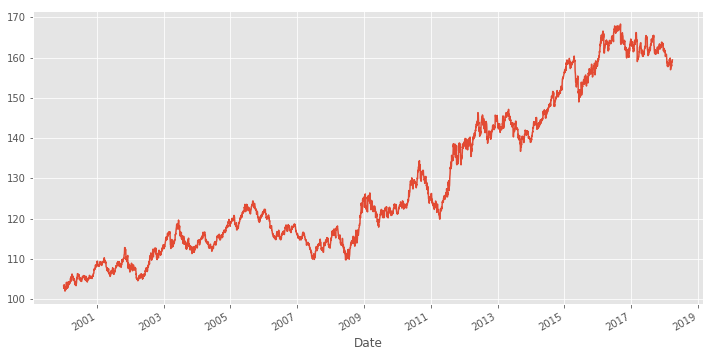

In [12]:
data_dict['FGBL']['FGBLc1']['CLOSE'].plot(figsize = (12,6)); # View on massive bull market in German Bunds

In [13]:
expiry_dates[-1] # let's inspect quickly what happened at the latest roll 

Timestamp('2018-03-08 00:00:00')

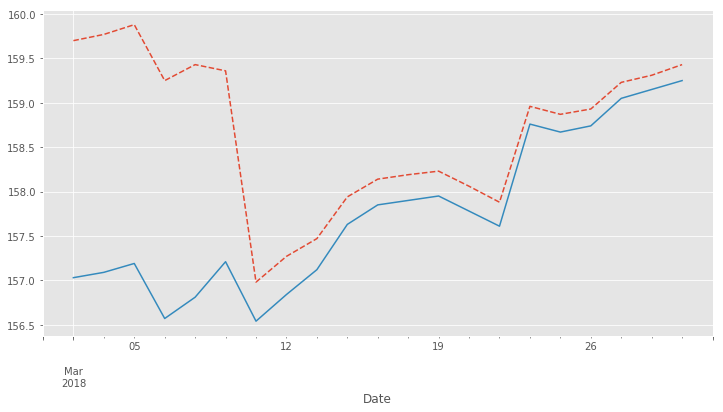

In [14]:
bund_front_contr = data_dict['FGBL']['FGBLc1']['CLOSE']['2018-3-1':].plot(style ='--')
gap = data_dict['FGBL']['FGBLc2']['CLOSE']['2018-3-1':].plot(ax = bund_front_contr, figsize = (12,6));
fig = gap.get_figure()
#fig.savefig('roll_gap.png', bbox_inches='tight')
# We start out with a huge gap. On the 8th "FGBLc1" get's pulled down because "FGBLc2" is the new "FGBLc1" now.
# We continue with a new gap because a new contract which at 1st March would have been "FGBLc3" is now "FGBLc2".

## Handeling the "Gap" in Spliced Futures Contracts

We will apply two methodologies on our Futures contracts in the following. Beforehand we give a short description of both.

**1. Continuously adjusting the contracts over time ("Perpetual/ Rollover Method")** 

The Perpetual Method applies weights to front and back contract over a pre-defined period of time. So to say, we trade out of the "old" contract into the "new" in a linear fashion. For instance, if we assume 5 roll-over days, we do the weighting according to the following scheme:

|Contract| Day 1| Day 2| Day 3|	Day 4|	Day 5|
|--------|------|------|------|------|-------|
|Front   |80%   |60%   |40%   |20%   |0%
|Back    |20%   |40%   |60%   |80%   |100%


The time when the front contract matures, we are already fully invested in the back or the then new front contract. That methodology basically smooths everything around roll and also gives kind of an explicit strategy how to roll the contract in case trading will be conducted. Nevertheless, one has to bare in mind that "smoothing" always means, we don't hit something exactly because we rather have a weighted mean (more to follow below). 

**2. Splicing contracts together with forward or backward adjustments ("Panama Adjustment")**

The Panama Adjustment either adjusts the actual (forward) or the historical (backward) contracts, such that they align in an exact fashion on expiry date. While overcoming the distortion on signal generation due to a continuous time series, we are left with biased relative price performance stemming from absolute series adjustments (the absolute gaps between contracts). This can also leads to potentially strong data trends, especially over long time horizons (with even the possibility of negative prices). However, the prior PnL or performance unit of Futures is the tick value, which still can be easily interpreted correctly, even if we would analyse a time series trending away substantially from the original Futures prices. Another drawback is that we possibly can't trade 100% accordingly because we have a rather sudden adjustment (more to follow below).

Just to add, we will adjust historical Futures for our Panama contract, because it's maybe more convenient to have the most recent contract marked where the market is actually trading.

In [15]:
def get_perp_fut(market_data, expiry_dates, rollover_days=5,             
                 data_cols=['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOLUME']):
    '''
    Converts a df of pairs of Futures contracts ('Front' & 'Back' ) into a continuous
    time series returned as df ("Perpetual Method").
    :param market_data: hierachical df as returned by EIKON Python API.
    :param expiry_dates: DatetimeIndex
    :param rollover_days: integer
    :param data_cols: str
    :return: df
    '''
    #Prepare Input Data
    market_data.columns.set_levels(['Front', 'Back'], 0, inplace = True)
    columns = pd.MultiIndex.from_tuples(tuple(zip(
        ['Front'] * len(data_cols) + ['Back'] * len(data_cols), data_cols * 2)
                                             ))
    #Initialize Weight Matrix
    roll_weights = pd.DataFrame(np.zeros((len(market_data.index), 2 * len(data_cols))),
                        index = market_data.index, columns=columns)
    #Weights depending on roll over days
    decay_weights = np.repeat(np.linspace(0, 1, rollover_days + 1),
                        int(len(data_cols))).reshape(rollover_days + 1,
                            int(len(data_cols)))
    #Update Weight Matrix
    for i in range(len(expiry_dates)):
        roll_weights.loc[expiry_dates[i]:, 'Front'] = 1
        roll_weights_target = roll_weights.iloc[
                            roll_weights.index.get_loc(expiry_dates[i]) - rollover_days :
                            roll_weights.index.get_loc(expiry_dates[i]) + 1
                            ].index 
        roll_weights.loc[roll_weights_target, 'Back'] = decay_weights
        roll_weights.loc[roll_weights_target, 'Front'] = 1 - decay_weights
    
    roll_weights_target = roll_weights.iloc[
                        0 : roll_weights.index.get_loc(expiry_dates[0]) - rollover_days
                        ].index
    roll_weights.loc[roll_weights_target, 'Front'] = 1
    #Update time-series data
    weighted_fut = roll_weights * market_data
    perp_fut = weighted_fut['Front'] + weighted_fut['Back'].fillna(0)
    return perp_fut

In [16]:
def get_pan_fut(market_data, expiry_dates, 
                data_cols=['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOLUME']):
    '''
    Converts a df of pairs of Futures contracts ('Front' & 'Back' ) into a continuous
    time series returned as df ("Panama Method"). Historic contracts are adjusted.
    :param market_data: hierachical df as returned by EIKON Python API.
    :param expiry_dates: DatetimeIndex
    :param data_cols: str
    :return: df
    
    '''
    #Prepare Input Data
    market_data.columns.set_levels(['Front', 'Back'], 0, inplace = True)
    #Initialize DFs for Futures data & roll adjustment for expired contracts
    pan_fut = pd.DataFrame(np.zeros((len(market_data.index), len(data_cols))), 
                        index = market_data.index, columns=data_cols)
    roll_adjustment_total = np.zeros([len(data_cols), 1])
    #Set data for last (unadjusted) Futures
    pan_fut.iloc[pan_fut.index.get_loc(expiry_dates[-1]) + 1:] = market_data['Front'].iloc[
        market_data['Front'].index.get_loc(expiry_dates[-1]) + 1:]
    #Find roll gap (we average over the last 5 trading days) backwards through contracts
    #and cumsum for total adjustment (due to better data quality we take all gaps from
    #close prices)
    for i in reversed(range(len(expiry_dates))):
        pan_fut.loc[expiry_dates[i]] = roll_adjustment_total.reshape(
            1, len(data_cols)) + market_data['Back'].loc[expiry_dates[i]].values
        roll_adjustment = market_data['Back']['CLOSE'].iloc[
            market_data['Front'].index.get_loc(expiry_dates[i]) - 4:
            market_data['Front'].index.get_loc(expiry_dates[i])
        ] - market_data['Front']['CLOSE'].iloc[
            market_data['Back'].index.get_loc(expiry_dates[i]) - 4:
            market_data['Back'].index.get_loc(expiry_dates[i])
        ]
        roll_adjustment = np.repeat(roll_adjustment.values.mean(), len(data_cols) - 1)
        roll_adjustment = np.append(roll_adjustment, 0)
        roll_adjustment = roll_adjustment.reshape(len(data_cols), 1)
        roll_adjustment_total += roll_adjustment
        #Most recent expired contract back to oldest + 1 contract
        if i > 0:
            roll_target = market_data['Front'].iloc[
                market_data['Front'].index.get_loc(expiry_dates[i - 1]) + 1:
                market_data['Front'].index.get_loc(expiry_dates[i])].index
            roll_adjustment_target = np.tile(roll_adjustment_total, len(roll_target)).T
            pan_fut.loc[roll_target] = roll_adjustment_target + market_data['Front'].loc[
                roll_target]
        #Oldest contract in data set
        else:
            roll_target = market_data['Front'].iloc[
                0:market_data['Front'].index.get_loc(expiry_dates[i])].index
            roll_adjustment_target = np.tile(roll_adjustment_total, len(roll_target)).T
            pan_fut.loc[roll_target] = roll_adjustment_target + market_data['Front'].loc[
                roll_target]
    return pan_fut


Add **Perpetual** and **Panama** time-series to **data_dict**. We use two roll-over period parameters for Perpetual.

In [17]:
for key in data_dict.copy().keys(): # execute only once as dict gets expanded "inplace"
    data_dict['%s_perp_10' % key] = get_perp_fut(
        data_dict[key], expiry_dates, rollover_days=10)
    data_dict['%s_perp_40' % key] = get_perp_fut(
        data_dict[key], expiry_dates, rollover_days=40)
    data_dict['%s_pan' % key] = get_pan_fut(data_dict[key], expiry_dates)

### Visual Analysis with Matplotlib

Let's start with the **Panama** series to get a feel how roll gaps accumalate over time.

In [18]:
plt.rcParams['figure.figsize'] = (12, 14)

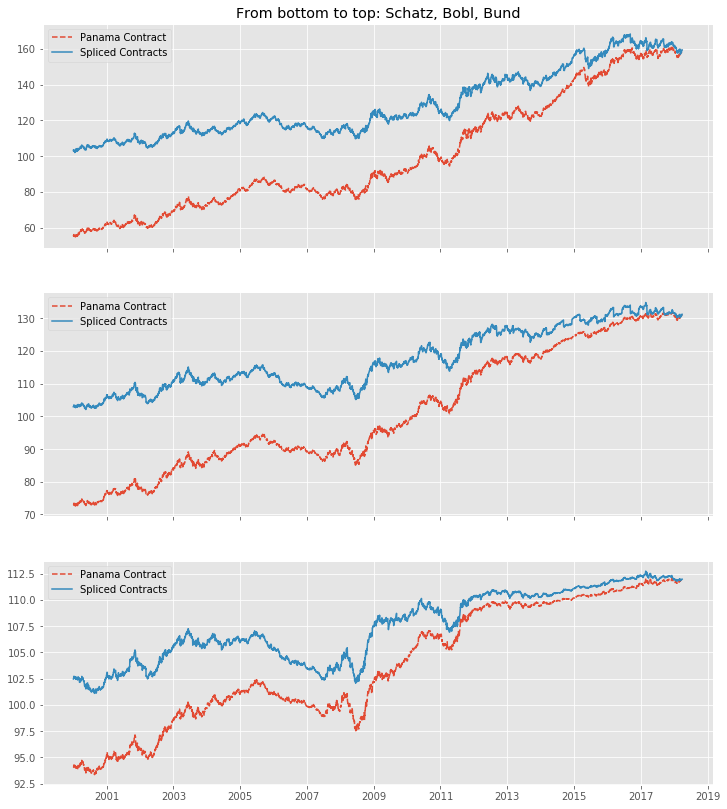

In [19]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(data_dict['FGBL_pan']['CLOSE'].index,
         data_dict['FGBL_pan']['CLOSE'], label='Panama Contract', linestyle='--')
axarr[0].plot(data_dict['FGBL']['Front']['CLOSE'].index,
         data_dict['FGBL']['Front']['CLOSE'], label='Spliced Contracts')
axarr[0].legend(loc='upper left')
axarr[0].set_title('From bottom to top: Schatz, Bobl, Bund')
axarr[1].plot(data_dict['FGBM_pan']['CLOSE'].index,
         data_dict['FGBM_pan']['CLOSE'], label='Panama Contract', linestyle='--')
axarr[1].plot(data_dict['FGBM']['Front']['CLOSE'].index,
         data_dict['FGBM']['Front']['CLOSE'], label='Spliced Contracts')
axarr[1].legend(loc='upper left')
axarr[2].plot(data_dict['FGBS_pan']['CLOSE'].index,
         data_dict['FGBS_pan']['CLOSE'], label='Panama Contract', linestyle='--')
axarr[2].plot(data_dict['FGBS']['Front']['CLOSE'].index,
         data_dict['FGBS']['Front']['CLOSE'], label='Spliced Contracts')
axarr[2].legend(loc='upper left');
f.savefig('panama_method_2000.png', bbox_inches='tight')

We see how large these adjustments in the Panama time-series can get and how they scale with the duration of the contract (Bunds having the highest, Schatz having the lowest duration). Probably also nice to see for people interested in very long term patterns, that simply spliced together Futures contracts should maybe taken with a pinch of salt.

Now we focus a bit more on the micro behaviour (i. e. what happens around roll-over). This is especially interesting for the **Perpetual** series, as we move away from the benchmark at the start of the roll, and gravitate back to it at the end.

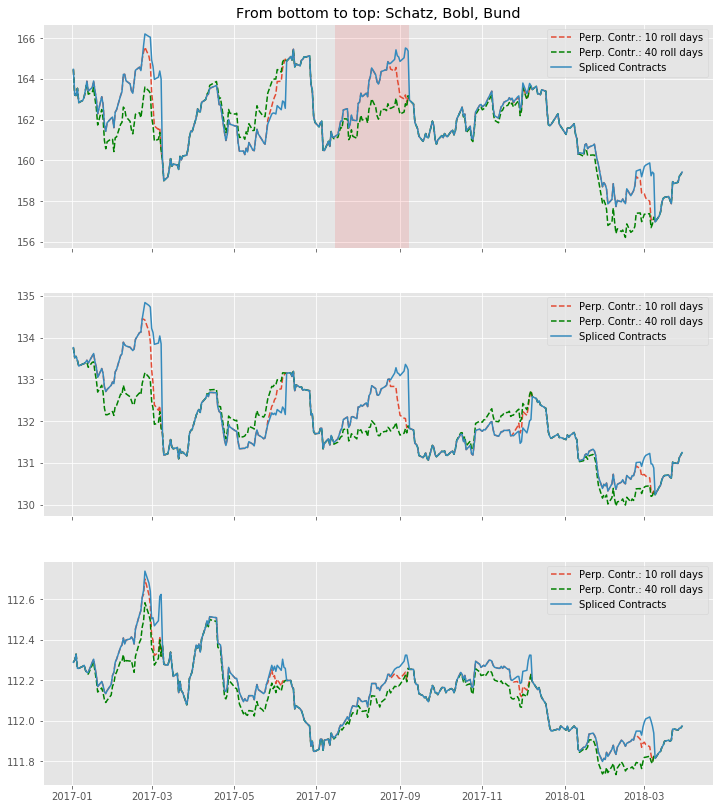

In [20]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].axvspan(pd.to_datetime('2017-7-15'),pd.to_datetime('2017-9-7'), color='red', alpha=0.1)
axarr[0].plot(data_dict['FGBL_perp_10']['CLOSE']['2017-1-1':].index,
         data_dict['FGBL_perp_10']['CLOSE']['2017-1-1':], label='Perp. Contr.: 10 roll days',
              linestyle='--')
axarr[0].plot(data_dict['FGBL_perp_40']['CLOSE']['2017-1-1':].index,
         data_dict['FGBL_perp_40']['CLOSE']['2017-1-1':], label='Perp. Contr.: 40 roll days',
              color='g', linestyle='--')
axarr[0].plot(data_dict['FGBL']['Front']['CLOSE']['2017-1-1':].index,
         data_dict['FGBL']['Front']['CLOSE']['2017-1-1':], label='Spliced Contracts')
axarr[0].legend(loc='upper right')
axarr[0].set_title('From bottom to top: Schatz, Bobl, Bund')
axarr[1].plot(data_dict['FGBM_perp_10']['CLOSE']['2017-1-1':].index,
         data_dict['FGBM_perp_10']['CLOSE']['2017-1-1':], label='Perp. Contr.: 10 roll days',
              linestyle='--')
axarr[1].plot(data_dict['FGBM_perp_40']['CLOSE']['2017-1-1':].index,
         data_dict['FGBM_perp_40']['CLOSE']['2017-1-1':], label='Perp. Contr.: 40 roll days',
              color='g', linestyle='--')
axarr[1].plot(data_dict['FGBM']['Front']['CLOSE']['2017-1-1':].index,
         data_dict['FGBM']['Front']['CLOSE']['2017-1-1':], label='Spliced Contracts')
axarr[1].legend(loc='upper right')
axarr[2].plot(data_dict['FGBS_perp_10']['CLOSE']['2017-1-1':].index,
         data_dict['FGBS_perp_10']['CLOSE']['2017-1-1':], label='Perp. Contr.: 10 roll days',
              linestyle='--')
axarr[2].plot(data_dict['FGBS_perp_40']['CLOSE']['2017-1-1':].index,
         data_dict['FGBS_perp_40']['CLOSE']['2017-1-1':], label='Perp. Contr.: 40 roll days',
              color='g', linestyle='--')
axarr[2].plot(data_dict['FGBS']['Front']['CLOSE']['2017-1-1':].index,
         data_dict['FGBS']['Front']['CLOSE']['2017-1-1':], label='Spliced Contracts')
axarr[2].legend(loc='upper right');
f.savefig('perpetual_method.png', bbox_inches='tight')

If we look at the highlighted area, we see that the short roll-over is so heavily influenced by the large negative gap, that it literally has to "run" down so many steps in spite of a slight upwards movement of the Bund during these days. In fact, thereby we introduce an artificial downward trend, which has never been there. If we extend the roll-over, we see the 40-days-series "mimicking" better what actually happened. But still, the upward trend is kind of "flattened out" and therefore not fully captured. So at least for the Bund a Perpetual time-series isn't a full success. Apparently, for the Schatz our series is doing much better from visual inspection.

Let's revisit our **Panama** series for an inspection around roll-over.

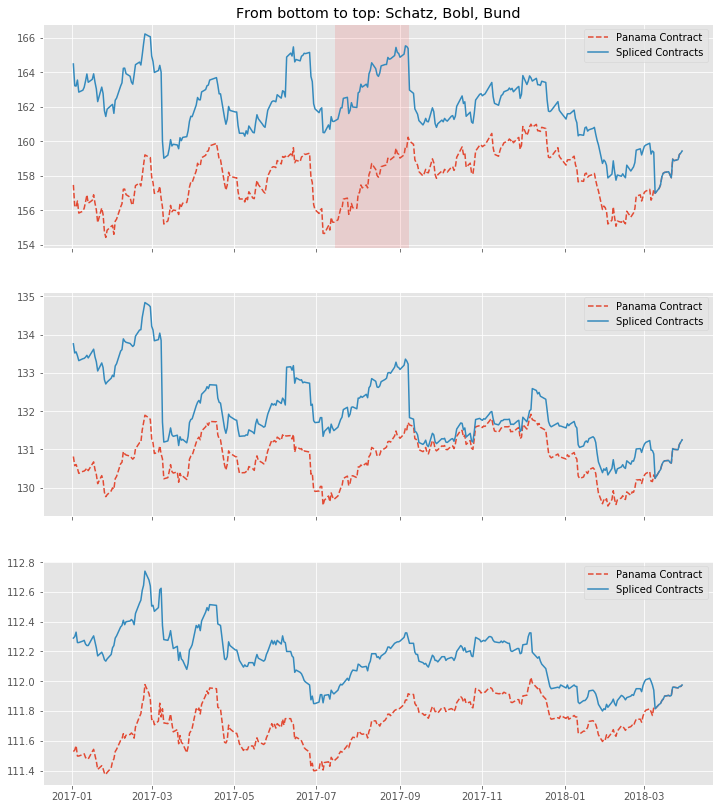

In [21]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].axvspan(pd.to_datetime('2017-7-15'),pd.to_datetime('2017-9-7'), color='red', alpha=0.1)
axarr[0].plot(data_dict['FGBL_pan']['CLOSE']['2017-1-1':].index,
         data_dict['FGBL_pan']['CLOSE']['2017-1-1':], label='Panama Contract',
              linestyle='--')
axarr[0].plot(data_dict['FGBL']['Front']['CLOSE']['2017-1-1':].index,
         data_dict['FGBL']['Front']['CLOSE']['2017-1-1':], label='Spliced Contracts')
axarr[0].legend(loc='upper right')
axarr[0].set_title('From bottom to top: Schatz, Bobl, Bund')
axarr[1].plot(data_dict['FGBM_pan']['CLOSE']['2017-1-1':].index,
         data_dict['FGBM_pan']['CLOSE']['2017-1-1':], label='Panama Contract',
              linestyle='--')
axarr[1].plot(data_dict['FGBM']['Front']['CLOSE']['2017-1-1':].index,
         data_dict['FGBM']['Front']['CLOSE']['2017-1-1':], label='Spliced Contracts')
axarr[1].legend(loc='upper right')
axarr[2].plot(data_dict['FGBS_pan']['CLOSE']['2017-1-1':].index,
         data_dict['FGBS_pan']['CLOSE']['2017-1-1':], label='Panama Contract',
              linestyle='--')
axarr[2].plot(data_dict['FGBS']['Front']['CLOSE']['2017-1-1':].index,
         data_dict['FGBS']['Front']['CLOSE']['2017-1-1':], label='Spliced Contracts')
axarr[2].legend(loc='upper right');
f.savefig('panama_method.png', bbox_inches='tight')

Probably not a big surprise that we fully capture the Bund (and the other Futures) movement during roll-over.

### Picking our Method of Choice

Above we couldn't identify a methodology were all lights had been on green: the Perpetual series was too heavily influenced by "closing" the roll gap, while the Panama contract has it's drawbacks in the "sudden" adjustment, which makes it tough to trade accordingly. 

Nevertheless, it is maybe a good idea - and we will do this in the following - to combine both. By closer inspection, you will already recognize that something like that was already done in the code for the Panama function earlier. So the idea is to average the backward adjustment over 5 days prior to Futures expiry. During the roll period, where basis between contracts tend to be volatile, one could - in absence of a certain view on the roll basis - therefore simply trade according to the Perpetual method. Thereby we stay highly accurate with regards to market direction during roll, and at the same time, are able to capture PnL fairly well in potential backtesting/ trading use-cases. Again, it's important to highlight that on a Panama tranformed Futures series, one should not use relative performance measures, but should rather stick with tick values for profitability assessments.

## Analysis with Plotly and Cufflinks

We further dig into the performance of our **Continuous Futures** by looking into signals generated from various technical indicators. We use some popular indicators, namely **EMA**, **Bollinger Bands**, **MACD**, and **RSI**. From those the latter two will be looked at extensively. As the **Panama Method** (with a little bit of input from the Perpetual Method) was most appealing to us, we spare charts from the **Perpetual Method** here. We do this in two sections: Firstly, we present **Ploty Charts** as a mean of comparison; afterwards we do some analysis on the generated signals by comparing the methods **quantitatively**.

### Visualization

Setting up objects to collect our 6 time-series.

In [22]:
plot_list = ['FGBL', 'FGBL_pan', 'FGBM', 'FGBM_pan', 'FGBS', 'FGBS_pan']
plot_titles = ['Bund Spliced', 'Bund Panama', 'Bobl Spliced',
               'Bobl Panama', 'Schatz Spliced', 'Schatz Panama']
qf_list = []

We start with generating **QuantFig** objects from **Cufflinks**. Also we slice the time frame to roughly a year due to usability of the charts later.

In [23]:
for i, j in enumerate(plot_list):
    if i % 2 == 0:
        qf_list.append(cf.QuantFig(
            data_dict[j]['Front']['2017-4-1':],
            title=plot_titles[i],
            legend='top',
            name=plot_titles[i],
            datalegend=False,
            rangeselector=dict(steps=['Reset','6M','3M','1M'],
                                    bgcolor=('rgb(150, 200, 250)',.1),
                                    fontsize=12, fontfamily='monospace', x=0, y=1)
        ))
    else:
        qf_list.append(cf.QuantFig(
            data_dict[j]['2017-4-1':],
            title=plot_titles[i],
            legend='top',
            name=plot_titles[i],
            datalegend=False,
            rangeselector=dict(steps=['Reset','6M','3M','1M'],
                                    bgcolor=('rgb(150, 200, 250)',.1),
                                    fontsize=12, fontfamily='monospace', x=0, y=1)
        ))

Enrich **QuantFigs** with **technical studies** and highlight **Futures Expiries**. Transform objects to a **Plotly Figure Object** for further editing.

In [24]:
for i, qf in enumerate(qf_list):
    for d in expiry_dates[-4:]:
        qf.add_shapes(shapes=dict(kind='line', x0=str(d), x1=str(d), yref='paper', y0=0, y1=1,
                          color='grey', dash='dot'))
    qf.add_volume(colorchange=True)
    qf.add_macd(fast_period=12, slow_period=26, signal_period=9, name='MACD')
    qf.studies['macd']['display'].update(legendgroup=True)
    qf.add_ema(colors='brown', name='EMA')
    qf.add_bollinger_bands(periods=20, boll_std=2, colors=['magenta', 'grey'], name='BOLL')
    qf.add_rsi(periods=20, rsi_upper=70, rsi_lower=30, name='RSI')
    # From here on we set everything on the dict level of the Plotly Figure object
    qf_list[i] = qf.iplot(asFigure = True)
    dict(qf_list[i])['data'][1]['showlegend'] = False
    dict(qf_list[i])['data'][3]['name'] = 'EMA'
    dict(qf_list[i])['data'][7]['showlegend'] = False
    dict(qf_list[i])['data'][8]['showlegend'] = False
    dict(qf_list[i])['data'][9]['showlegend'] = False
    dict(qf_list[i])['data'][0]['showlegend'] = False

Next we define a dict **global_layout**, where we place all information that we want to add to the **Plotly Figure Object**.

First step of editing targets the appearance in form of **size and proportions** of the Plotly chart.

In [25]:
global_layout = {}
for qf in range(len(qf_list)):
    # Set Chart proportions & subplot titles
    global_layout['layout%s' % (qf,)] = {'layout': {
        'width':800,
        'height':700,
        'margin': {
            'l':55,
            'r':30,
            'b':30,
            't':30},
        'yaxis2': {
            'domain': (0.39, 1),
       'gridcolor': '#E1E5ED',
       'showgrid': True,
       'tickfont': {'color': '#4D5663'},
       'title': 'Price',
       'titlefont': {'color': '#4D5663'},
       'zerolinecolor': '#E1E5ED'
        },
        'yaxis3': {
            'domain': (0.26, 0.36),
       'gridcolor': '#E1E5ED',
       'showgrid': True,
       'tickfont': {'color': '#4D5663'},
       'title': 'VOL',
       'titlefont': {'color': '#4D5663'},
       'zerolinecolor': '#E1E5ED'
        },
      'yaxis4': {
          'domain': (0.13, 0.23),
       'gridcolor': '#E1E5ED',
       'showgrid': True,
       'tickfont': {'color': '#4D5663'},
       'title': 'MACD',
       'titlefont': {'color': '#4D5663'},
       'zerolinecolor': '#E1E5ED'
      },
      'yaxis5': {
          'domain': (0.0, 0.1),
       'gridcolor': '#E1E5ED',
       'showgrid': True,
       'tickfont': {'color': '#4D5663'},
       'title': 'RSI',
       'titlefont': {'color': '#4D5663'},
       'zerolinecolor': '#E1E5ED'
      }}}
    qf_list[qf].update(global_layout['layout%s' % (qf,)])
   

Next, we create a dict, **signals**, where we collect all trading signals for **MACD** and **RSI**. The signals are then written back to **global_layout** to appear visually in the Plotly chart. That is to get an easy visual mean of comparison between **Spliced** and **Panama** Futures series. We will also use that data in our **quantitative analysis** on generated trading signals.

In [26]:
signals = {}
for qf in range(len(qf_list)):
    # Prepare Annotations by collecting the signals that have occured
    ## MACD
    macd = pd.DataFrame(data=[dict(qf_list[qf])['data'][2]['y'],
                              dict(qf_list[qf])['data'][1]['y']]).T
    macd['Date'] = dict(qf_list[qf])['data'][1]['x']
    macd.set_index('Date', inplace = True)
    macd.columns = ['Signal', 'Basis']
    macd['Signal'].replace(0, np.nan, inplace = True)
    macd['Up'] = np.where(macd['Signal'] > macd['Basis'], 1, 0)
    macd['Cross'] = np.where(macd['Up'] - macd['Up'].shift() == 0, 0, 'MACD Signal')
    macd['Cross'].iloc[:2] = 0 #ignore cross due to lack of data
    ## RSI
    rsi = pd.DataFrame(data=[dict(qf_list[qf])['data'][7]['y'],
                             dict(qf_list[qf])['data'][8]['y'],
                             dict(qf_list[qf])['data'][9]['y']]).T
    rsi['Date'] = dict(qf_list[qf])['data'][7]['x']
    rsi.set_index('Date', inplace = True)
    rsi.columns = ['Signal', 'Lower', 'Upper']
    rsi['Signal'].replace('', np.nan, inplace = True)
    rsi.dropna(inplace = True)
    rsi['Up'] = np.where(rsi['Signal'] > rsi['Upper'], 1, 0)
    rsi['Up_Cross'] = np.where(rsi['Up'] - rsi['Up'].shift() == 0, 0, 1)
    rsi['Down'] = np.where(rsi['Signal'] < rsi['Lower'], 1, 0)
    rsi['Down_Cross'] = np.where(rsi['Down'] - rsi['Down'].shift() == 0, 0, 1)
    rsi['Sum_Cross'] = np.where(rsi['Up_Cross'] == 1, 'RSI Signal',
                                np.where(rsi['Down_Cross'] == 1, 'RSI Signal', 0))
    rsi['Sum_Cross'].iloc[:1] = 0 #ignore cross due to lack of data
    ## Set Signals per Security and Study to dict
    signals["Sec%s" % (qf,)] = {}
    if qf % 2 != 0:
        signals["Sec%s" % (qf,)]['MACD'] = data_dict[plot_list[qf]].join(
            macd.loc[macd['Cross'] == 'MACD Signal']['Cross'],
                                    how = 'inner')['HIGH']
        signals["Sec%s" % (qf,)]['RSI'] = data_dict[plot_list[qf]].join(
                                    rsi.loc[rsi['Sum_Cross'] == 'RSI Signal']['Sum_Cross'],
                                    how = 'inner')['LOW']
    else:
        signals["Sec%s" % (qf,)]['MACD'] = data_dict[plot_list[qf]]['Front'].join(
                                    macd.loc[macd['Cross'] == 'MACD Signal']['Cross'],
                                    how = 'inner')['HIGH']
        signals["Sec%s" % (qf,)]['RSI'] = data_dict[plot_list[qf]]['Front'].join(
                                    rsi.loc[rsi['Sum_Cross'] == 'RSI Signal']['Sum_Cross'],
                                    how = 'inner')['LOW']
    # Update Annotations
    global_layout['layout%s' % (qf,)]['layout']['annotations'] = []
    for i in signals['Sec%s' % (qf,)].keys():
        for j, (key, value) in enumerate(signals['Sec%s' % (qf,)][i].iteritems()):
            if i == 'MACD':
                if j % 10 == 0: # annotate every 10th signal with "MACD"
                    global_layout['layout%s' % (qf,)]['layout']['annotations'].append(dict(
                                x=key,
                                y=value,
                                xref='x',
                                yref='yaxis2',
                                text=i,
                                showarrow=True,
                                arrowhead=2,
                                ax=0,
                                ay=-70
                            ))
                else:
                    global_layout['layout%s' % (qf,)]['layout']['annotations'].append(dict(
                                x=key,
                                y=value,
                                xref='x',
                                yref='yaxis2',
                                text='',
                                showarrow=True,
                                arrowhead=2,
                                ax=0,
                                ay=-10
                            ))
            else:
                if j % 10 == 0: # annotate every 10th signal with "RSI"
                    global_layout['layout%s' % (qf,)]['layout']['annotations'].append(dict(
                                x=key,
                                y=value,
                                xref='x',
                                yref='yaxis2',
                                text=i,
                                showarrow=True,
                                arrowhead=7,
                                ax=0,
                                ay=70
                            ))
                else:
                    global_layout['layout%s' % (qf,)]['layout']['annotations'].append(dict(
                                x=key,
                                y=value,
                                xref='x',
                                yref='yaxis2',
                                text='',
                                showarrow=True,
                                arrowhead=7,
                                ax=0,
                                ay=0
                            ))
    qf_list[qf].update(global_layout['layout%s' % (qf,)])

Now all chart information for every time-series sits in **qf_list**. Let us start comparing by plotting the **Bund** in **Spliced** vs. **Panama**.

In [27]:
iplot(qf_list[0])

In [28]:
iplot(qf_list[1])

### Div export for HTML embedding

In [29]:
#plot(qf_list[0], show_link = False, include_plotlyjs=False, output_type='div')

In [30]:
#plot(qf_list[1], show_link = False, include_plotlyjs=False, output_type='div')

Probably a bit of exploring the data, hovering around, getting a look and feel now makes sense. As describing would get quite lengthy, just as summary, that indeed, signals do get influenced by the choose of our continuous Futures methodology.

### Quantifying the Trading Signals

Now we leverage on the data we wrote to **global_layout** and **signals** in the above section. Here we simply print out some statistics on our trading signals.

In [31]:
print('Signal count for Bund, Bobl, Schatz (separated by:\'--\'):\n\n', 7* ' ','MACD', 'RSI')
for i in range(len(plot_list)): #we iterate over all Futures
    no_macd_sig = 0
    no_rsi_sig = 0
    if i % 2 == 0: print(17*'-')
    for j in global_layout['layout%s' %i]['layout']['annotations']: #we use our annotations from before and count
        if (j['arrowhead']) == 2: #"arrowhead" was marking the respective technical study.
            no_macd_sig += 1
        else:
            no_rsi_sig += 1
    if i % 2 == 0: print('Spliced ',no_macd_sig,' ',no_rsi_sig)
    else: print('Panama  ',no_macd_sig,' ',no_rsi_sig)

Signal count for Bund, Bobl, Schatz (separated by:'--'):

         MACD RSI
-----------------
Spliced  18   34
Panama   18   35
-----------------
Spliced  12   22
Panama   16   19
-----------------
Spliced  21   18
Panama   15   21


In [32]:
signal_dates = {} #dict as container
for i in range(len(plot_list)): #lists for date collections
    signal_dates['layout%s' %i] = {}
    signal_dates['layout%s' %i]['MACD'] = []
    signal_dates['layout%s' %i]['RSI'] = []
    for j in global_layout['layout%s' %i]['layout']['annotations']: #write all signal dates per security and tech 
        if (j['arrowhead']) == 2:                                   #study to list in dict "signal_dates"
            signal_dates['layout%s' %i]['MACD'].append(j['x']) 
        else:
            signal_dates['layout%s' %i]['RSI'].append(j['x'])

In [33]:
print('Signal Dates NOT shared by Spliced and Panama contract '
      'for Bund, Bobl, Schatz (separated by:\'--\'):\n\n',
      3*' ', 'Unique Dates')
for i in range(0,len(plot_list),2): #pair wise comparison if signal date in "Spliced" is in "Panama" et vice versa.
    print(17*'-')
    print('MACD     ',len(
        [x for x in signal_dates['layout%s' %i]['MACD'] if x not in 
         signal_dates['layout%s' %(i+1)]['MACD']]) + len(
        [x for x in signal_dates['layout%s' %(i+1)]['MACD'] if x not in
         signal_dates['layout%s' %i]['MACD']]))
    print('RSI      ',len(
        [x for x in signal_dates['layout%s' %i]['RSI'] if x not in 
         signal_dates['layout%s' %(i+1)]['RSI']]) + len(
        [x for x in signal_dates['layout%s' %(i+1)]['RSI'] if x not in
         signal_dates['layout%s' %i]['RSI']]))
    

Signal Dates NOT shared by Spliced and Panama contract for Bund, Bobl, Schatz (separated by:'--'):

     Unique Dates
-----------------
MACD      22
RSI       17
-----------------
MACD      24
RSI       15
-----------------
MACD      28
RSI       13


The numbers in the above tables give a clear direction: The absolute number of signals per indicator can change and also the day on which they occur. 

## Outcome

Together the above findings clearly indicate that construction of Continuous Futures time-series needs to be carefully conducted. Our example with German Government Bond Futures may not be fully representative for the whole Futures space, but nevertheless advices for sensible research before trading algorithms are set up. It would be relatively straight forward to extend the above analysis to a realistic trading scenario.

## References

- https://www.quantstart.com/articles/Continuous-Futures-Contracts-for-Backtesting-Purposes
- http://www.ipedr.com/vol29/48-CEBMM2012-R00003.pdf
- http://www.seykota.com/tribe/TSP/Continuous/index.htm